# Transfer Learning with TensorFlow Part 2: Fine-tuning 👀

In [1]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Create helper functions

It a good idea to put functions you'll want to use again in a script you can download and import into your notebooks.

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-02-11 02:13:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-11 02:13:41 (89.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-02-11 02:13:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.207, 172.217.214.207, 172.253.114.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   105MB/s    in 1.5s    

2024-02-11 02:13:44 (105 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



## Let's get some data

This time we'll see how we can use pretrained models. <br>
Within `tf.keras.applications` and apply tem to ourown problem. <br>
We qill use `10%` of food data.

In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [5]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


> Using new way of ImageDataGenerator 🐼

In [7]:
# Check out the class names of our class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is stright-forward, it runs our layers in sequential order.

But thefunctional API gives more flexibility with our models.  🖥️

In [8]:
tf.random.set_seed(42)

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained are not update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_layer")

# 4. If using a model like ResNet50V2 you need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to base model
x = base_model(inputs)
print(f"Shape after passing inputs hrough base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information)
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePoolingLayers")(x)
print(f"Shape after GlobalAveragePooling: {x.shape}")

# 7. Create the output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="Output_layer")(x)

# 8. Combine the imputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile a model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save the history
history_10_percent =  model_0.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25*len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name="TransferLearning", experiment_name="10percnt_feature_extraction")]) #Validation only 25% for time saving

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs hrough base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling: (None, 1280)
Saving TensorBoard log files to: TransferLearning/10percnt_feature_extraction/20240211-021400
Epoch 1/5
24/24 [==============================] - 19s 351ms/step - loss: 1.9571 - accuracy: 0.3827 - val_loss: 1.3634 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 4s 144ms/step - loss: 1.1313 - accuracy: 0.7600 - val_loss: 0.9122 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 3s 129ms/step - loss: 0.8058 - accuracy: 0.8280 - val_loss: 0.7158 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 5s 174ms/step - loss: 0.6431 - accuracy: 0.8680 - val_loss: 0.6469 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 4s 131ms/step - loss: 0.5516 - accuracy: 0.8827 - val_loss: 0.5671 - val_accuracy: 0.8586


In [9]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.5604 - accuracy: 0.8584


[0.5604113936424255, 0.8583999872207642]

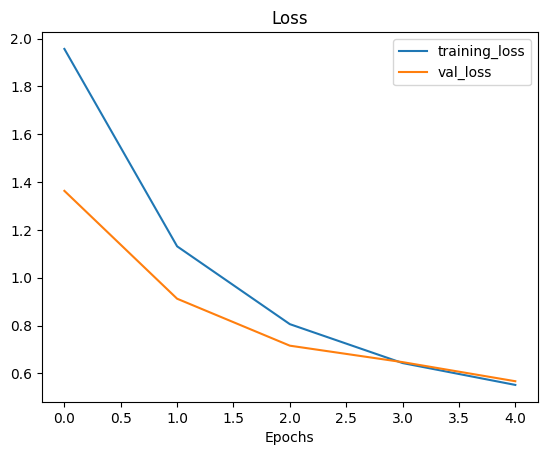

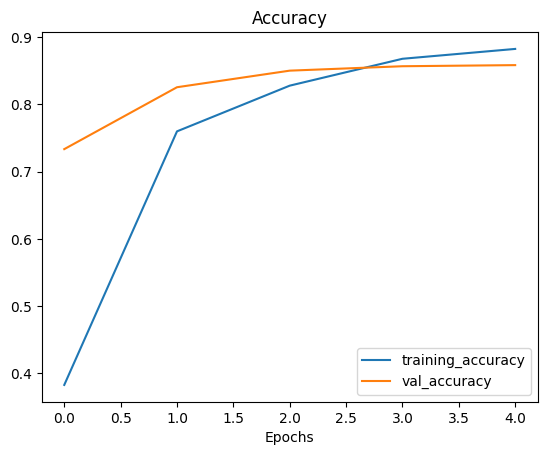

In [10]:
# Check out our model training curves
plot_loss_curves(history=history_10_percent)

## Getting a feature vector from a trained model

Let's demostrate the Gloval Average Pooling 2D layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

Then when it pass through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shape tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [11]:
# Define the input shape
input_shape=(1, 4, 4 ,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(input_tensor, "\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(global_average_pooled_tensor)

tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32) 

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


> shape(1, 4, 4, 3) -> (1, 3). From 4D to 2D. 🔨

In [12]:
# Let's replocate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a Series of Transfer Learning Experiments

1. `model_1` - use feature extraction transfer learning with 1% of training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

🔑 **Note:** All experiments the same dataset will be used to evaluate our model. This ensure coonsistency across evaluation metrics.

### Getting and preprocessing data for model_1 🖥️

In [13]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-02-11 02:14:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.207, 173.194.206.207, 142.251.171.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   137MB/s    in 0.9s    

2024-02-11 02:14:54 (137 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [14]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [15]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

In [16]:
# Setup data and loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # Default

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # Default

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()` <br><br><br>

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmentating them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation happens only during training, so we can use it elsewhere.

In [17]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
])

### Visualize our data augmentation layer (and see what happens to our data) 🥹

(-0.5, 511.5, 383.5, -0.5)

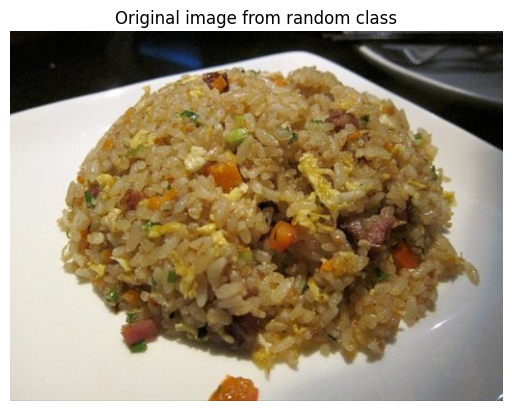

In [18]:
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
image = mpimg.imread(random_image_path)
plt.imshow(image)
plt.title("Original image from random class")
plt.axis(False)

# Modle 1 : Feature extration transfer learning on 1% of the data with data augmentation

In [19]:
tf.random.set_seed(42)

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentaion as a layer
x = data_augmentation(inputs)

# Give base model an input
x = base_model(x , training=False)

# Pool te output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="PoolingLayers")(x)

# Put a dense layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model
model_1 = tf.keras.Model(inputs, outputs)

# Compile a model
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)

# Fit the data
history_1_percent_model_1 = model_1.fit(
    train_data_1_percent,
    steps_per_epoch=len(train_data_1_percent),
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    callbacks=[create_tensorboard_callback(dir_name="TransferLearning", experiment_name="1percnt_feature_extraction")]
)


Saving TensorBoard log files to: TransferLearning/1percnt_feature_extraction/20240211-021500
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.4253 - accuracy: 0.1143 - val_loss: 2.2881 - val_accuracy: 0.1497
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1611 - accuracy: 0.2286 - val_loss: 2.1462 - val_accuracy: 0.2582
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9868 - accuracy: 0.3429 - val_loss: 2.0460 - val_accuracy: 0.3174
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7697 - accuracy: 0.5571 - val_loss: 1.9369 - val_accuracy: 0.3684
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6662 - accuracy: 0.5429 - val_loss: 1.8556 - val_accuracy: 0.3964


In [20]:
# Evaluate on the full test dataset
reault_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 1.8566 - accuracy: 0.4024


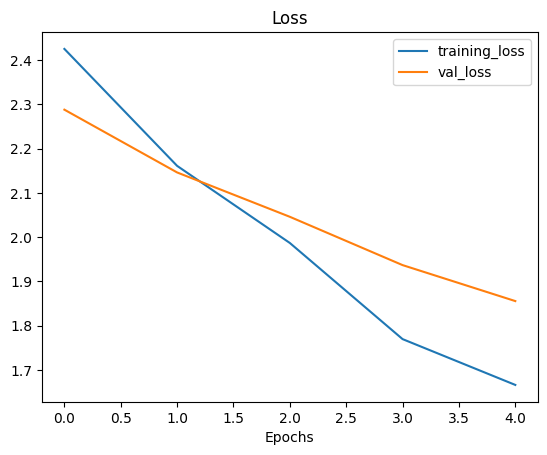

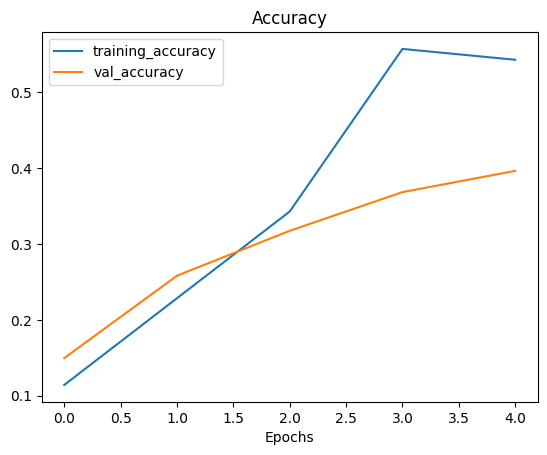

In [21]:
# How do the model go with 1% data augmentation?
plot_loss_curves(history_1_percent_model_1)

## Model 2 with 10% of data with augmentation

In [22]:
tf.random.set_seed(42)

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentaion as a layer
x = data_augmentation(inputs)

# Give base model an input
x = base_model(x , training=False)

# Pool te output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="PoolingLayers")(x)

# Put a dense layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model
model_2 = tf.keras.Model(inputs, outputs)

# Compile a model
model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)

### Creating a `ModelCheckpoint` callback

The `ModelMheckpoint` callback intermediately saves our model(the full model or gust the weights) during training. <br>
This is useful so we can come and start where we left over.

In [23]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that save model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose = 1)

In [24]:
# Fitting the model 2
initial_epochs = 5
history_10_percent_model_2 = model_2.fit(train_data_10_percent,
                                         epochs = initial_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25*len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name="TransferLearning",
                                                                                experiment_name="10_percent_data_aug"),
                                                    checkpoint_callback])

Saving TensorBoard log files to: TransferLearning/10_percent_data_aug/20240211-021551
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9781 - accuracy: 0.3853
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 31s 981ms/step - loss: 1.9781 - accuracy: 0.3853 - val_loss: 1.3862 - val_accuracy: 0.6941
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2715 - accuracy: 0.7293
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 689ms/step - loss: 1.2715 - accuracy: 0.7293 - val_loss: 0.9571 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9921 - accuracy: 0.7520
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 806ms/step - loss: 0.9921 - accuracy: 0.7520 - val_loss: 0.7860 - val_accuracy: 0.8240
Ep

In [25]:
# Test model 2
result_10_percent_aug = model_2.evaluate(test_data)

79/79 [==============================] - 5s 64ms/step - loss: 0.6140 - accuracy: 0.8468


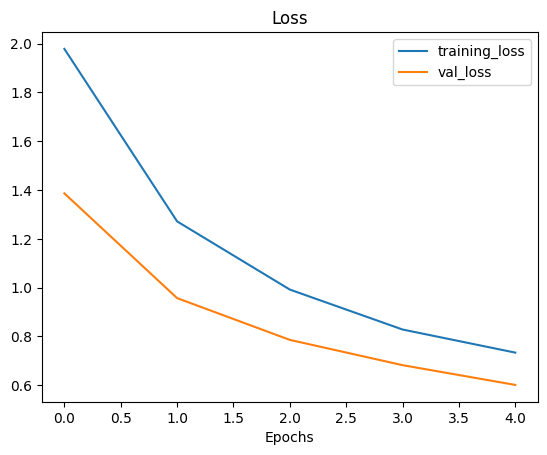

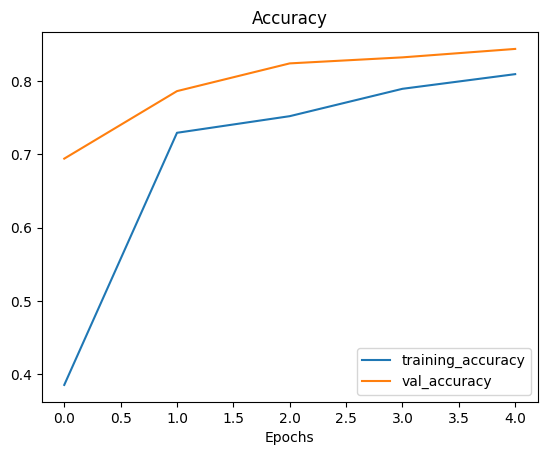

In [26]:
# Plot the loss curves
plot_loss_curves(history_10_percent_model_2)

## Model 3: fine-tuning an existing model on 10% of the data 🖥️

> 🔑 **Note:** Fine-tuning usually works best  *after* training a feature extraction model.

In [27]:
# Layers in loaded model
model_2.layers

In [28]:
# Are these trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7ed15ff80850> True
<keras.src.engine.sequential.Sequential object at 0x7ed15fe70340> True
<keras.src.engine.functional.Functional object at 0x7ed15949dba0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7ed1540c51e0> True
<keras.src.layers.core.dense.Dense object at 0x7ed15949f5b0> True


In [47]:
# How many trainable in our base model
print(len(model_2.layers[2].trainable_variables))

10


In [48]:
# To begin fine tuning. Let's start by last ten layers of our base modle trainable
base_model.trainable = True

# Freeze all layers except last ten
for layer in base_model.layers[:-10]:
  layer.trainable = False

# How many trainable in our base model
print("How many trainable in our base model:",len(model_2.layers[2].trainable_variables))

# Re-compile our model evertime we made a change
model_2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), # When fine-tuning we got lower it by 10X
    metrics=["accuracy"]
)

How many trainable in our base model: 10


In [49]:
# Fine-tuning for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_model_2.epoch[-1], # Start from last epoch last time
                                               callbacks = [create_tensorboard_callback(dir_name="TransferLearning",
                                                                                        experiment_name="10_percent_fine_tuning")]
                                               )

Saving TensorBoard log files to: TransferLearning/10_percent_fine_tuning/20240211-023255
Epoch 5/10
24/24 [==============================] - 23s 604ms/step - loss: 0.2938 - accuracy: 0.9120 - val_loss: 0.4219 - val_accuracy: 0.8618
Epoch 6/10
24/24 [==============================] - 13s 523ms/step - loss: 0.2561 - accuracy: 0.9267 - val_loss: 0.4444 - val_accuracy: 0.8586
Epoch 7/10
24/24 [==============================] - 13s 546ms/step - loss: 0.2244 - accuracy: 0.9413 - val_loss: 0.4335 - val_accuracy: 0.8668
Epoch 8/10
24/24 [==============================] - 13s 522ms/step - loss: 0.1992 - accuracy: 0.9520 - val_loss: 0.4310 - val_accuracy: 0.8536
Epoch 9/10
24/24 [==============================] - 14s 592ms/step - loss: 0.1941 - accuracy: 0.9507 - val_loss: 0.4311 - val_accuracy: 0.8701
Epoch 10/10
24/24 [==============================] - 11s 440ms/step - loss: 0.1703 - accuracy: 0.9547 - val_loss: 0.4194 - val_accuracy: 0.8618


In [50]:
# Evaluate with whole test data
model_2.evaluate(test_data)

79/79 [==============================] - 6s 63ms/step - loss: 0.4076 - accuracy: 0.8680


[0.40763863921165466, 0.8679999709129333]

> `plot_loss_curves()` fit only for epochs=5

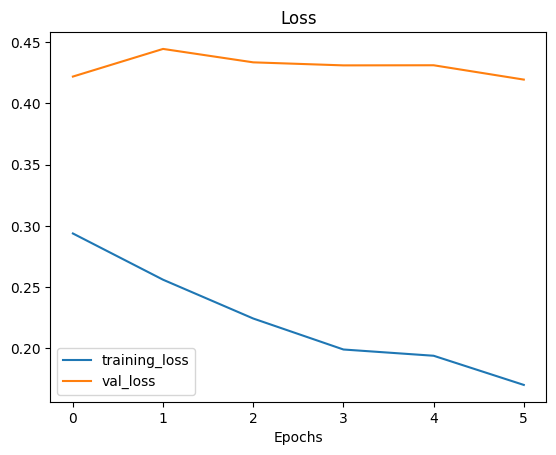

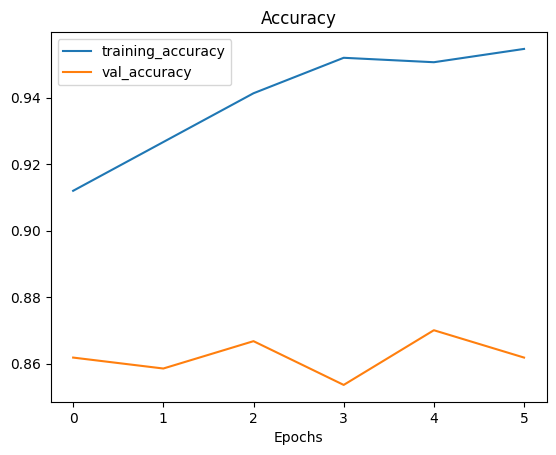

In [51]:
# Plot loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

In [52]:
# let's create a fnction
def compare_history(original_history, new_history, initial_epochs=5):

  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine with afte rfine tuning
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_accuracy"]

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc)
  plt.plot(total_val_acc)
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.title("Training and Validation accuracy")

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss)
  plt.plot(total_val_loss)
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.title("Training and Validation loss")

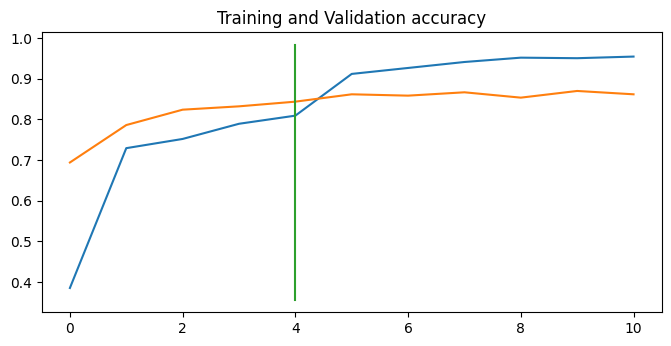

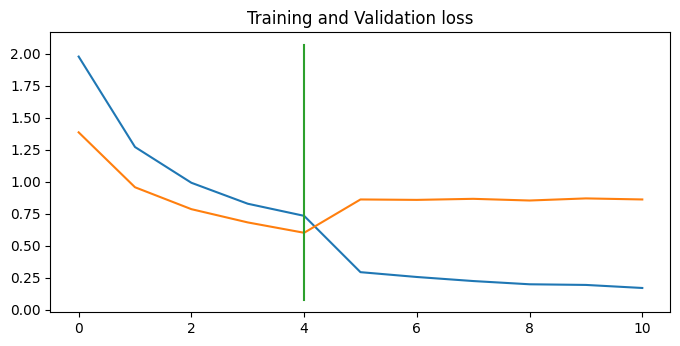

In [53]:
compare_history(history_10_percent_model_2, history_fine_10_percent_data_aug)

## Model4: Fine-tuning with whole data

In [54]:
# Downliad data unzi data
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"
unzip_data("10_food_classes_all_data.zip")

--2024-02-11 02:34:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.207, 142.251.6.207, 172.217.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  90.6MB/s    in 8.5s    

2024-02-11 02:35:05 (58.5 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [55]:
# Set up training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir_all_data = "10_food_classes_all_data/test"

In [56]:
# How many are we working with?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.

In [57]:
# Set up data input
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### To train a fine-tuning (model_4) we need to revert model_2 back to its feature extraction weight.

In [58]:
# Load weight from check weight, that we can fine-tuining same stage
model_2.load_weights(checkpoint_path)

In [61]:
# Compile
model_2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [63]:
# Contine to train and fine-tining the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classs_full = model_2.fit(train_data_10_classes_full,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          initial_epoch=history_10_percent_model_2.epoch[-1],
                                          callbacks=[create_tensorboard_callback(dir_name="TransferLearning",
                                                                                 experiment_name="Full_10class_fine_tuning")])

Saving TensorBoard log files to: TransferLearning/Full_10class_fine_tuning/20240211-024229
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.8121

235/235 [==============================] - 81s 341ms/step - loss: 0.5794 - accuracy: 0.8121 - val_loss: 0.3575 - val_accuracy: 0.8882
Epoch 6/10
235/235 [==============================] - 73s 308ms/step - loss: 0.4847 - accuracy: 0.8433 - val_loss: 0.2991 - val_accuracy: 0.9046
Epoch 7/10
235/235 [==============================] - 67s 285ms/step - loss: 0.4407 - accuracy: 0.8583 - val_loss: 0.2939 - val_accuracy: 0.8898
Epoch 8/10
235/235 [==============================] - 63s 265ms/step - loss: 0.4067 - accuracy: 0.8701 - val_loss: 0.2922 - val_accuracy: 0.8980
Epoch 9/10
235/235 [==============================] - 62s 264ms/step - loss: 0.3682 - accuracy: 0.8795 - val_loss: 0.2645 - val_accuracy: 0.9145
Epoch 10/10
235/235 [==============================] - 56s 237ms/step - loss: 0.3439 - accuracy: 0.8888 - val_loss: 0.2819 - val_accuracy: 0.9079


In [64]:
# Let's evaluate all test data
model_2.evaluate(test_data_10_classes_full)

79/79 [==============================] - 7s 76ms/step - loss: 0.2674 - accuracy: 0.9192


[0.26735612750053406, 0.9192000031471252]

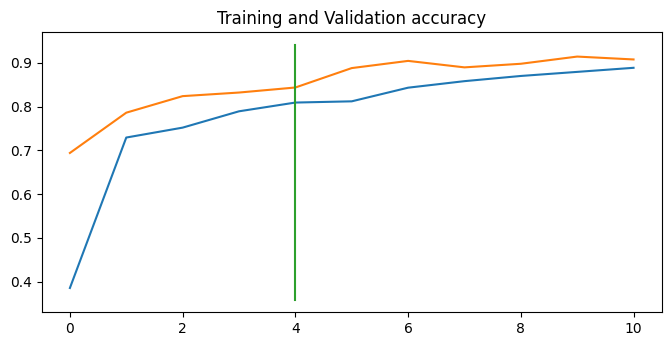

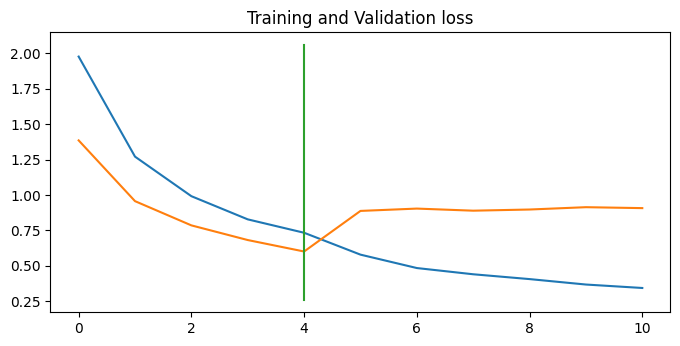

In [66]:
compare_history(original_history=history_10_percent_model_2, new_history=history_fine_10_classs_full)